In [1]:
import numpy as np
import pandas as pd
import string
import sys, os, re, csv, codecs

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, GRU, Conv1D, Embedding, Dropout, Activation, concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import model_from_json

np.random.seed(42)

C:\Users\sandra\Anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
from google.colab import files

uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [3]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "glove.6B.50d.txt" with length 171350079 bytes
User uploaded file "test.csv" with length 60354593 bytes
User uploaded file "train.csv" with length 68802655 bytes


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [4]:
list_sentences_train = train["comment_text"].fillna("_na_")
list_sentences_test = test["comment_text"].fillna("_na_")

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes]

In [5]:
embed_size = 50 # how big is each word vector
num_words = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 500 # max number of words in a comment to use

In [6]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

# Simple LSTM baseline

In [0]:
model = Sequential()
model.add(Embedding(num_words, embed_size, input_length=maxlen))
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(6, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.fit(X_train, y, batch_size=64, epochs=2, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 935s 7ms/step - loss: 0.0720 - acc: 0.9775 - val_loss: 0.0521 - val_acc: 0.9816
Epoch 2/2
143613/143613 [==============================] - 878s 6ms/step - loss: 0.0465 - acc: 0.9829 - val_loss: 0.0513 - val_acc: 0.9821


# Improved LSTM with GloVe
Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [7]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

In [8]:
glove='glove.6B.50d.txt'

In [9]:
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(glove,encoding='utf-8'))
all_embs = np.stack(embeddings_index.values())
all_embs=all_embs.astype('float32') 

In [10]:
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940516, 0.6441044)

In [11]:
word_index = tokenizer.word_index
nb_words = min(num_words, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= num_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [0]:
len(word_index)

210337

In [13]:
int_to_vocab=[0] * (len(word_index)+1)
for word, i in word_index.items():
    int_to_vocab[i]=word

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embedding_matrix[:viz_words, :])

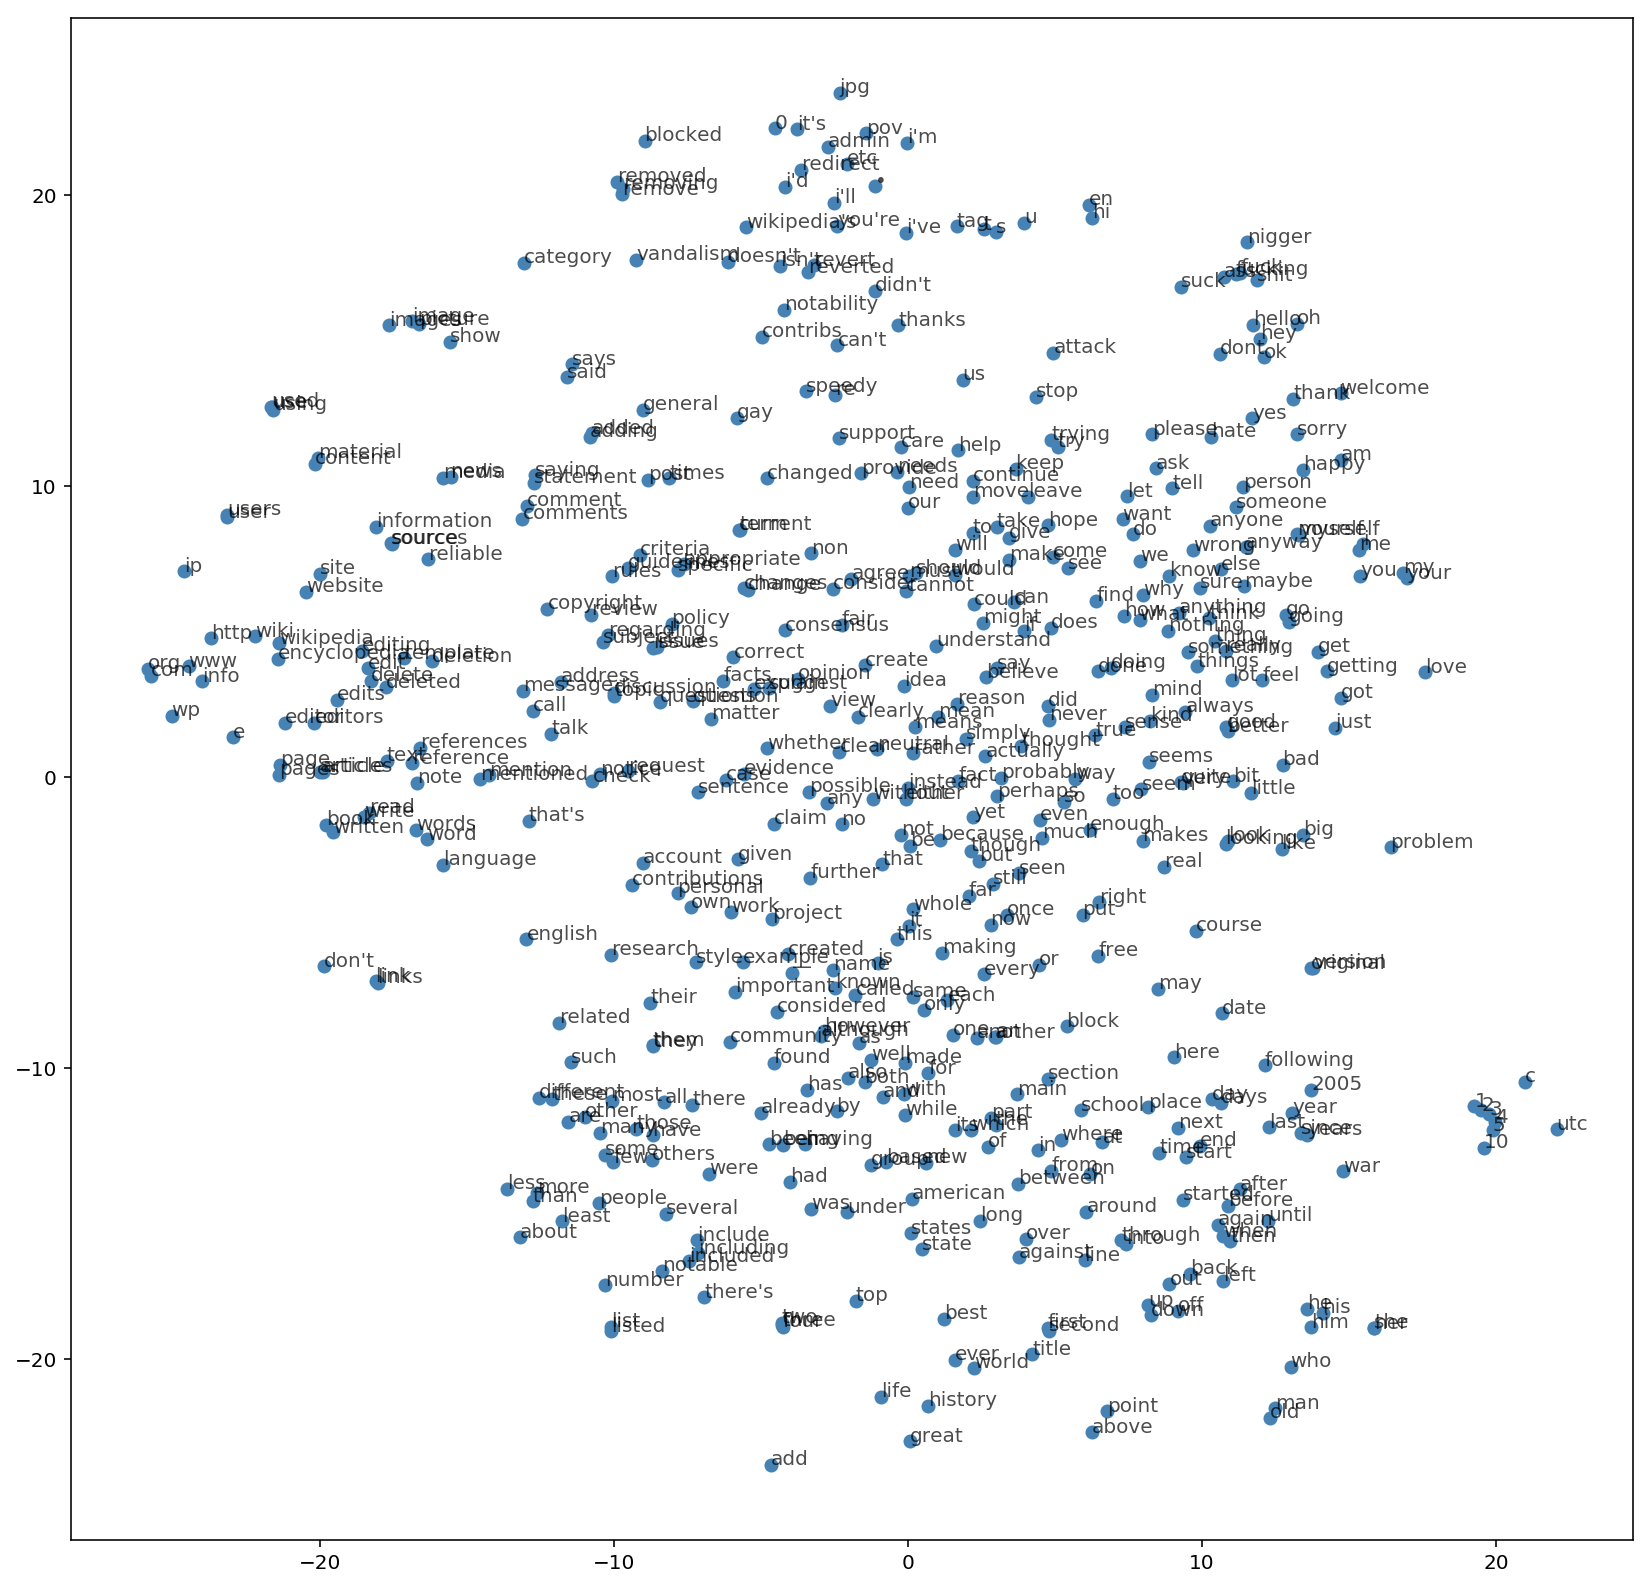

In [0]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [11]:
model = Sequential()
model.add(Embedding(num_words, embed_size, input_length=maxlen, weights=[embedding_matrix]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
model.add(Dense(6, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.fit(X_train, y, batch_size=128, epochs=2, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 4610s 32ms/step - loss: 0.0768 - acc: 0.9756 - val_loss: 0.0513 - val_acc: 0.9812
Epoch 2/2
143613/143613 [==============================] - 4392s 31ms/step - loss: 0.0505 - acc: 0.9816 - val_loss: 0.0477 - val_acc: 0.9825


# LSTM + GRU + Concatenate layer

In [12]:
inp = Input(shape=(maxlen,))
x = Embedding(num_words, embed_size, input_length=maxlen, weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Bidirectional(GRU(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dropout(0.1)(x)
out = Dense(6, activation='sigmoid')(x)
model = Model(inp, out)

adam = optimizers.adam(clipvalue=0.5)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [13]:
model.fit(X_train, y, batch_size=64, epochs=2, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 8322s 58ms/step - loss: 0.0804 - acc: 0.9740 - val_loss: 0.0534 - val_acc: 0.9811
Epoch 2/2
143613/143613 [==============================] - 9868s 69ms/step - loss: 0.0546 - acc: 0.9806 - val_loss: 0.0490 - val_acc: 0.9818


# GRU and CNN with callback

In [0]:
from keras.optimizers import Adam
from keras import callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [0]:
filepath="weights.best.hdf5"
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [early, checkpoint]

In [16]:
model = Sequential()
model.add(Embedding(num_words, embed_size, input_length=maxlen, weights=[embedding_matrix]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(6, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [17]:
model.fit(X_train, y, batch_size=64, epochs=2, validation_split=0.1, callbacks = callbacks_list)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1113s 8ms/step - loss: 0.0667 - acc: 0.9770 - val_loss: 0.0502 - val_acc: 0.9820==>.] - ETA: 0s - loss: 0.0667 - acc: 0.977

Epoch 00001: val_acc improved from -inf to 0.98195, saving model to weights.best.hdf5
Epoch 2/2
143613/143613 [==============================] - 1106s 8ms/step - loss: 0.0477 - acc: 0.9823 - val_loss: 0.0469 - val_acc: 0.9827==>.] - ETA: 0s - loss: 0.0477 - acc: 0.982

Epoch 00002: val_acc improved from 0.98195 to 0.98266, saving model to weights.best.hdf5


In [14]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model_c.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_c.h5")
print("Saved model to disk")

Saved model to disk


In [15]:
# load json and create model
from keras.models import model_from_json

json_file = open('model_LG.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_LG.h5")
print("Loaded model from disk")

Loaded model from disk


In [16]:
y_test = loaded_model.predict([X_test], batch_size=1024, verbose=1)

153164/153164 [==============================] - 211s 1ms/step


In [17]:
pd.DataFrame(y_test).head(2)

,0,1,2,3,4,5
0,0.987691,0.391642,0.944953,0.081521,0.878512,0.247650
1,0.001435,0.000004,0.000258,0.000012,0.000154,0.000056


In [18]:
idd = pd.DataFrame(test['id'])
#idd.to_csv('id.csv', index=False)

In [19]:
submission = pd.DataFrame(y_test, columns=list_classes)
submission = idd.join(submission)
submission.head(2)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.987691,0.391642,0.944953,0.081521,0.878512,0.247650
1,0000247867823ef7,0.001435,0.000004,0.000258,0.000012,0.000154,0.000056


In [20]:
submission.to_csv('submission_c.csv', index=False)

In [0]:
files.download('submission2.csv')